In [1]:
import os
import numpy as np
import pandas as pd
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

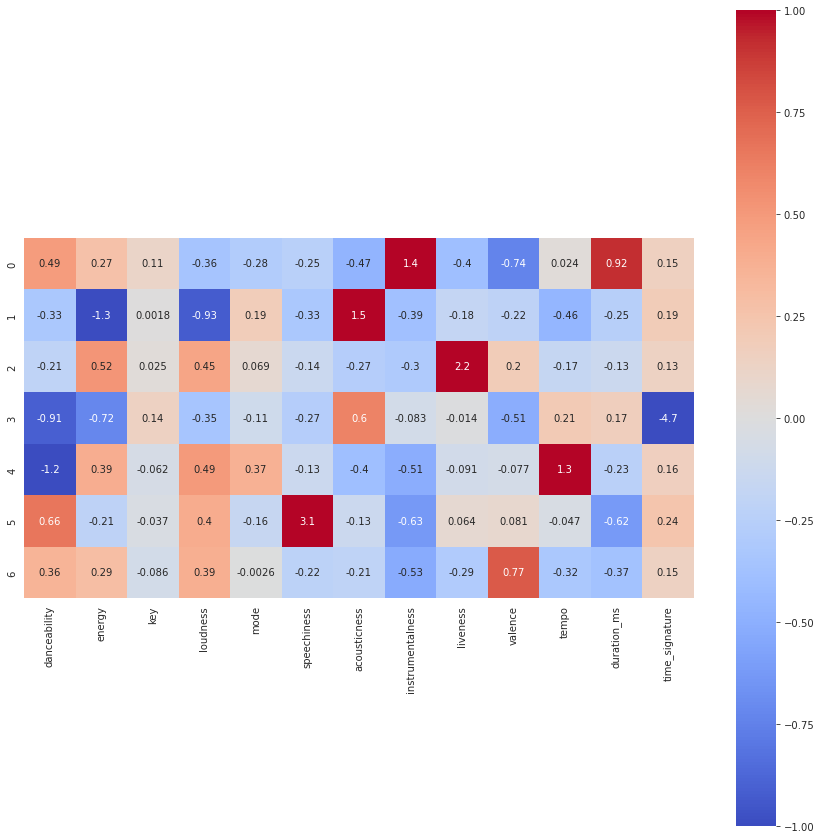

In [5]:
## create a dataframe of audio feature records called 'df' using everything in directory 'indir' as input
indir = 'Data/audio_features/'
infile_list = os.listdir(indir)

dfs = []
for fname in infile_list:
    dfs.append(pd.read_csv(os.path.join(indir, fname), index_col=None))
    
df = pd.concat(dfs, axis=0)
df = df.drop_duplicates().reset_index(drop=True)

## create X_scaled_df (the input used for modeling)
X = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
        'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

## use the StandardScaler model we fit during modeling (or just run fit again)
fitted_scaler = load("Model/nina-scaler.pickle")
X_scaled = fitted_scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

## load the trained model with the best k
kmeans_7_all = load("Model/nina-kmeans_7.pickle")

# create new col in main df with the cluster label the model assigned to each track
df['k7_cluster'] = kmeans_7_all.labels_

## create dictionary of cluster membership for each label
cluster_labels = np.unique(df.k7_cluster)
cluster_members = {}
for cluster in cluster_labels:
    cluster_members[cluster] = np.where(df.k7_cluster == cluster)

## for each cluster label (ky) calculate the mean for each feature
scaled_feature_means_by_cluster = pd.DataFrame([X_scaled_df.loc[cluster_members[ky]].mean(numeric_only=True) for ky in cluster_members.keys()])

## --- plot results as heatmap
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(scaled_feature_means_by_cluster, cmap='coolwarm', vmin=-1, vmax=1, annot=True, square=True)